# Forecasting Inflation with AutoML in Amazon SageMaker Autopilot

## 1. Set up the environment

Import the dependencies.

In [1]:
import io
import json
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Get the SageMaker session.

In [2]:
session = sagemaker.Session()

Get the SageMaker execution role.

In [3]:
role = sagemaker.get_execution_role()

Get the default S3 bucket.

In [4]:
bucket = session.default_bucket()

## 2. Define the auxiliary functions for working with the FRED-MD data

In [5]:
def transform_series(
    x,
    tcode
):
    """
    Transform the time series.

    Parameters:
    ========================================================================================================
    x: pandas.Series
        Time series.
    
    tcode: int.
        Transformation code.
    """
    
    if tcode == 1:
        # No transformation
        return x
    
    elif tcode == 2:
        # First order absolute difference
        return x.diff()
    
    elif tcode == 3:
        # Second order absolute difference
        return x.diff().diff()
    
    elif tcode == 4:
        # Logarithm
        return np.log(x)
    
    elif tcode == 5:
        # First order logarithmic difference
        return np.log(x).diff()
    
    elif tcode == 6:
        # Second order logarithmic difference
        return np.log(x).diff().diff()
    
    elif tcode == 7:
        # Percentage change
        return x.pct_change()
    
    else:
        raise ValueError(f"unknown `tcode` {tcode}")

In [6]:
def get_common_series(
    start_vintage,
    end_vintage
):
    """
    Get the list of complete time series included in all dataset releases between two vintages.
    
    Parameters:
    ========================================================================================================
    start_vintage: str.
        The first vintage, in "YYYY-MM" format.

    end_vintage: str.
        The last vintage, in "YYYY-MM" format.
    """
    # Generate the date range
    dates = pd.date_range(
        start=f"{start_vintage.split('-')[0]}-{start_vintage.split('-')[1]}-01",
        end=f"{end_vintage.split('-')[0]}-{end_vintage.split('-')[1]}-01",
        freq="MS"
    )
    
    # Create a list for storing the names of the complete time series
    series = []
    
    # Loop across the dates
    for date in dates:
        # Load the data for the considered date
        data = pd.read_csv(f"data/{date.year}-{format(date.month, '02d')}.csv", skiprows=list(range(1, 11)), index_col=0)
        
        # Drop the incomplete time series
        data = data.loc[:, data.isna().sum() == 0]
        
        # Save the names of the complete time series
        series.append([c.upper() for c in data.columns])
    
    # Get the list of complete time series included in the dataset on all dates
    series = list(set.intersection(*map(set, series)))
    
    return series

In [7]:
def get_data(
    vintage,
    series_names,
    target_name,
    target_tcode,
    n_lags,
):
    """
    Get the data for a selected vintage.

    Parameters:
    ========================================================================================================
    vintage: str.
        The vintage of the dataset, in "YYYY-MM" format.
    
    series_names: str.
        The time series to be included in the dataset.
    
    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.
    """
    # Get the file path
    file = f"data/{vintage}.csv"
    
    # Get the time series
    data = pd.read_csv(file, skiprows=list(range(1, 11)), index_col=0)
    data.index = pd.to_datetime(data.index)
    data.columns = [c.upper() for c in data.columns]
    data = data.loc[:, series_names]
    
    # Get the transformation codes
    tcodes = pd.read_csv(file, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    # Override the target's transformation code
    tcodes[target_name] = target_tcode
    
    # Transform the time series
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))
    
    # Add the lags
    data = data[[target_name]].join(data.shift(periods=list(range(1, 1 + n_lags)), suffix="_LAG"))
    
    # Drop the missing values resulting from applying the transformations and taking the lags
    data = data.dropna()
    
    return data

In [8]:
def get_real_time_data(
    start_vintage,
    end_vintage,
    series_names,
    target_name,
    target_tcode,
    n_lags,
):

    """
    Get the real-time data between two vintages.
    
    Parameters:
    ========================================================================================================
    start_vintage: str.
        The first vintage, in "YYYY-MM" format.

    end_vintage: str.
        The last vintage, in "YYYY-MM" format.

    series_names: str.
        The time series to be included in the dataset.
    
    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.
    """
    
    # Generate the date range
    dates = pd.date_range(
        start=f"{start_vintage.split('-')[0]}-{start_vintage.split('-')[1]}-01",
        end=f"{end_vintage.split('-')[0]}-{end_vintage.split('-')[1]}-01",
        freq="MS"
    )
    
    # Get the last month of data for each date in the considered range
    data = pd.concat([
        get_data(
            vintage=f"{date.year}-{format(date.month, '02d')}",
            series_names=series_names,
            target_name=target_name,
            target_tcode=target_tcode,
            n_lags=n_lags,
        ).iloc[-1:]
        for date in dates
    ])

    return data

## 3. Prepare the FRED-MD data and upload it to S3

Select the target name.

In [9]:
target_name = "CPIAUCSL"

Select the target transformation code.

In [10]:
target_tcode = 7

Select the number of autoregressive lags.

In [11]:
n_lags = 1

Get the names of the complete time series over the relevant time window.

In [12]:
series_names = get_common_series(
    start_vintage="2023-01",
    end_vintage="2025-01",
)

In [13]:
print(f"Number of complete time series: {len(series_names)}")

Number of complete time series: 101


**Note:** Make sure that the target has a complete time series.

In [14]:
print(f"Target time series is complete: {target_name in series_names}")

Target time series is complete: True


### 3.1 Training data (January 1960 - December 2022)

Get the training data.

In [15]:
training_data = get_data(
    vintage="2023-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [16]:
training_data.shape

(756, 102)

In [17]:
training_data.head()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,-0.001360,0.008364,0.006704,-0.01,0.003017,0.2,1.15,0.029464,0.34,0.003433,...,0.02,0.014685,-0.000333,0.059984,0.031476,-0.003763,0.000551,0.004405,0.001839,0.000000
1960-02-01,0.001362,-0.013330,-0.000464,0.00,0.003017,0.3,1.04,0.024097,-0.14,0.004561,...,0.03,0.036326,-0.002591,0.025914,-0.017594,0.000647,-0.001716,-0.001429,-0.001786,0.000000
1960-03-01,0.000000,-0.018942,-0.000189,-0.02,-0.003017,-0.2,0.69,-0.005683,-0.39,-0.010291,...,-0.05,0.006457,0.003765,-0.008936,-0.039545,0.002493,0.001593,0.001767,0.001674,-0.002990
1960-04-01,0.004420,0.003490,-0.008009,-0.13,0.011976,-0.1,0.18,-0.003429,-0.65,0.009155,...,-0.07,0.002154,-0.004555,-0.009020,-0.013719,-0.000161,-0.000491,0.001576,0.001786,0.005979
1960-05-01,0.001016,0.024136,0.017105,0.08,-0.011976,-0.4,0.12,0.002289,-0.08,0.010198,...,-0.04,-0.010784,0.004119,-0.007958,0.012822,0.000438,0.003114,0.003930,0.004439,-0.000009


In [18]:
training_data.tail()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2022-08-01,0.001182,0.003287,-0.000073,0.47,-0.060036,-0.1,1.37,0.004367,0.74,-0.003552,...,-0.18,0.006900,-0.009318,0.005143,0.003272,-0.000103,-0.010793,0.002690,-0.026734,-0.025811
2022-09-01,0.003860,-0.004031,0.004405,0.65,0.010593,-0.1,0.95,0.002509,0.40,0.003838,...,0.01,0.008360,0.006974,-0.000123,0.061189,-0.013178,0.003610,0.002564,-0.002537,-0.002098
2022-10-01,0.004384,-0.007437,-0.000577,0.23,0.020397,0.0,1.31,0.000292,0.50,-0.002945,...,0.52,0.006879,-0.000350,0.003436,-0.076961,0.016471,0.000758,0.001102,0.003919,0.004990
2022-11-01,0.000963,-0.005410,0.000164,0.52,0.009191,0.0,1.35,0.003857,0.59,0.004762,...,0.51,0.003535,-0.010346,-0.000305,-0.032860,0.021950,0.000333,0.001895,0.012451,0.007365
2022-12-01,-0.000794,0.009727,-0.000723,0.70,-0.011403,-0.2,0.98,-0.006252,0.43,0.002443,...,-0.20,-0.017999,-0.002480,-0.005846,0.050102,-0.029478,-0.002800,-0.000220,-0.009422,-0.008130


Upload the training data to S3.

In [19]:
training_data_s3_uri = session.upload_string_as_file_body(
    body=training_data.to_csv(index=False),
    bucket=bucket,
    key="data/train.csv"
)

### 3.2 Validation data (January 2023 - December 2023)

Get the validation data.

In [20]:
validation_data = get_real_time_data(
    start_vintage="2023-02",
    end_vintage="2024-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [21]:
validation_data.shape

(12, 102)

In [22]:
validation_data.head()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.005171,0.007180,0.002665,0.32,-0.022677,-0.1,0.59,-0.008693,0.10,0.002568,...,-0.47,-0.019965,0.003440,-0.010236,-0.001305,-0.036260,0.000349,0.001743,-0.006173,-0.005383
2023-02-01,0.003700,-0.000911,0.005236,0.23,0.032118,0.2,0.36,0.001569,0.29,-0.006234,...,-0.03,0.013519,0.004755,0.004046,0.012265,-0.008083,0.003697,0.001475,0.014202,0.010707
2023-03-01,0.000530,-0.005507,0.002523,0.24,-0.021180,-0.1,0.36,0.001373,0.11,0.004620,...,0.16,-0.004712,-0.004371,0.002080,0.029608,0.001838,-0.003025,0.001804,-0.004152,-0.001806
2023-04-01,0.003678,-0.020746,0.002883,0.08,-0.012886,0.1,0.03,0.002176,0.04,0.013393,...,0.04,-0.013917,0.001011,0.000469,-0.027615,-0.000324,-0.002040,0.000165,-0.006456,-0.005256
2023-05-01,0.001241,0.001289,-0.000258,0.18,0.025095,-0.1,-0.15,0.007172,0.23,0.000947,...,-0.13,0.012405,0.002947,0.005079,0.037807,-0.029607,0.002477,0.000397,0.006602,0.009193


In [23]:
validation_data.tail()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.006312,-0.000162,0.000910,0.04,-0.000571,0.0,0.25,0.008146,0.09,0.007459,...,0.01,0.009133,-0.003658,0.007054,0.036760,-0.031706,0.000462,0.002972,-0.000896,-0.001537
2023-09-01,0.003957,-0.005784,0.004395,0.21,0.023908,-0.1,0.04,0.000301,0.05,0.003110,...,0.29,0.001387,0.003862,0.000266,-0.011315,0.006855,0.001618,0.000000,0.013981,0.010637
2023-10-01,0.000449,0.003250,0.000536,0.00,-0.015126,0.0,0.11,-0.000882,0.02,-0.003720,...,0.18,-0.009161,0.002306,0.000693,-0.010886,0.023962,0.000061,0.002634,-0.010742,-0.008900
2023-11-01,0.000969,-0.004454,-0.001198,0.00,-0.036844,-0.2,0.09,-0.006722,0.02,0.003574,...,0.48,-0.008446,-0.001815,-0.008928,-0.032197,0.004326,-0.003487,0.001840,-0.006273,-0.005464
2023-12-01,0.003030,0.009237,0.002406,0.00,0.020665,-0.1,-0.05,0.000499,-0.07,-0.007270,...,-0.33,0.010063,-0.001558,-0.000284,0.043689,-0.014830,-0.000932,0.000739,-0.005660,-0.002133


Upload the training data to S3.

In [24]:
validation_data_s3_uri = session.upload_string_as_file_body(
    body=validation_data.to_csv(index=False),
    bucket=bucket,
    key="data/valid.csv"
)

### 3.3 Test data (January 2024 - December 2024)

Get the test data.

In [25]:
test_data = get_real_time_data(
    start_vintage="2024-02",
    end_vintage="2025-01",
    series_names=series_names,
    target_name=target_name,
    target_tcode=target_tcode,
    n_lags=n_lags,
)

In [26]:
test_data.shape

(12, 102)

In [27]:
test_data.head()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.003054,0.018582,-0.004029,0.0,0.001213,0.1,-0.37,-0.001021,-0.03,-0.003732,...,-0.54,-0.002527,0.000147,0.000005,0.049214,-0.028948,0.001285,0.001738,0.004867,0.004052
2024-02-01,0.004421,-0.009787,-0.001046,0.0,-0.004673,0.0,-0.54,-0.003519,-0.02,0.011177,...,0.13,-0.012971,0.006635,-0.004557,0.025174,-0.006613,0.002512,-0.000536,-0.002684,-0.002688
2024-03-01,0.003781,-0.005802,0.000896,0.0,0.019468,0.1,-0.41,0.001838,0.02,-0.016554,...,0.16,0.019414,-0.000164,0.004399,0.042276,0.020736,-0.000851,-0.000471,0.010236,0.007238
2024-04-01,0.003129,0.019568,0.002797,0.0,-0.017605,0.0,-0.34,0.003315,0.00,0.001750,...,-0.02,-0.001543,-0.001215,0.001212,0.031156,0.013026,-0.000003,0.001690,-0.004683,-0.003119
2024-05-01,0.000057,-0.027820,0.000518,0.0,0.006856,0.1,-0.19,-0.001789,0.00,0.002928,...,0.27,-0.005808,-0.002964,-0.000787,-0.011296,0.023688,-0.000750,0.000227,0.002735,0.001190


In [28]:
test_data.tail()

,CPIAUCSL,INVEST_LAG_1,CLF16OV_LAG_1,FEDFUNDS_LAG_1,WPSFD49502_LAG_1,AWOTMAN_LAG_1,T1YFFM_LAG_1,IPFPNSS_LAG_1,TB3MS_LAG_1,IPNCONGD_LAG_1,...,AAA_LAG_1,IPBUSEQ_LAG_1,DDURRG3M086SBEA_LAG_1,INDPRO_LAG_1,S&P 500_LAG_1,EXSZUSX_LAG_1,PCEPI_LAG_1,USWTRADE_LAG_1,DNDGRG3M086SBEA_LAG_1,CUSR0000SAC_LAG_1
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-08-01,0.001872,-0.004054,0.002497,0.00,0.011281,0.1,-0.43,-0.009938,-0.04,0.000262,...,-0.01,-0.010162,-0.003081,-0.009475,0.022435,-0.002352,0.000355,0.001182,0.003807,0.002651
2024-09-01,0.001799,0.001127,0.000712,0.00,-0.003891,0.0,-0.90,0.003034,-0.15,-0.007394,...,-0.25,0.001878,0.000591,0.003373,-0.010855,-0.038642,-0.000488,0.000065,-0.002222,-0.000136
2024-10-01,0.002441,-0.001682,0.000890,-0.20,-0.004573,0.0,-1.10,-0.005332,-0.33,0.000465,...,-0.19,-0.036034,0.005731,-0.004817,0.025777,-0.012551,0.000636,0.000986,-0.002590,-0.000555
2024-11-01,0.003129,-0.000451,-0.001305,-0.30,0.003122,0.0,-0.63,-0.005974,-0.21,0.006637,...,0.27,-0.032296,-0.002776,-0.004066,0.029977,0.016506,0.000577,0.000663,0.002392,0.001549
2024-12-01,0.003931,-0.011813,-0.000736,-0.19,0.012327,0.0,-0.32,0.002791,-0.09,0.000939,...,0.19,0.013492,-0.000123,0.001659,0.023478,0.022501,-0.001163,0.000549,0.001712,0.003667


Upload the test data to S3.

**Note:** Make sure to drop the target time series from the test dataset before uploading to S3.

In [29]:
test_data_s3_uri = session.upload_string_as_file_body(
    body=test_data.drop(labels=[target_name], axis=1).to_csv(index=False, header=False),
    bucket=bucket,
    key="data/test.csv"
)

## 4. Configure and run the AutoML job

Define the AutoML job configuration.

In [30]:
automl = sagemaker.automl.automlv2.AutoMLV2(
    problem_config=sagemaker.automl.automlv2.AutoMLTabularConfig(
        target_attribute_name=target_name,
        algorithms_config=["randomforest", "extra-trees", "xgboost", "linear-learner", "nn-torch"],
        mode="ENSEMBLING",
        problem_type="Regression",
    ),
    job_objective={"MetricName": "MSE"},
    base_job_name="us-cpi",
    output_path=f"s3://{bucket}/output/",
    role=role,
    sagemaker_session=session,
)

Run the AutoML job.

In [31]:
automl.fit(
    inputs=[
        sagemaker.automl.automlv2.AutoMLDataChannel(
            s3_data_type="S3Prefix",
            s3_uri=training_data_s3_uri,
            channel_type="training",
            compression_type=None,
            content_type="text/csv;header=present"
        ),
        sagemaker.automl.automlv2.AutoMLDataChannel(
            s3_data_type="S3Prefix",
            s3_uri=validation_data_s3_uri,
            channel_type="validation",
            compression_type=None,
            content_type="text/csv;header=present"
        ),
    ]
)

{"AutoMLJobName": "us-cpi-2025-09-02-19-49-10-182", "AutoMLJobInputDataConfig": [{"DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "s3://sagemaker-eu-west-1-661670223746/data/train.csv"}}, "ChannelType": "training", "ContentType": "text/csv;header=present"}, {"DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "s3://sagemaker-eu-west-1-661670223746/data/valid.csv"}}, "ChannelType": "validation", "ContentType": "text/csv;header=present"}], "OutputDataConfig": {"S3OutputPath": "s3://sagemaker-eu-west-1-661670223746/output/"}, "AutoMLProblemTypeConfig": {"TabularJobConfig": {"TargetAttributeName": "CPIAUCSL", "ProblemType": "Regression", "Mode": "ENSEMBLING", "CandidateGenerationConfig": {"AlgorithmsConfig": [{"AutoMLAlgorithms": ["randomforest", "extra-trees", "xgboost", "linear-learner", "nn-torch"]}]}}}, "RoleArn": "arn:aws:iam::661670223746:role/service-role/AmazonSageMaker-ExecutionRole-20191030T162743", "AutoMLJobObjective": {"MetricName": "MSE"}, "S

Get the best model.

In [32]:
automl.best_candidate()

{'CandidateName': 'WeightedEnsemble-L2-t2661670223746us-cpi-2025-09-02-19-49-10-182',
 'FinalAutoMLJobObjectiveMetric': {'Type': 'Minimize',
  'MetricName': 'MSE',
  'Value': 4.2978408600902185e-06,
  'StandardMetricName': 'MSE'},
 'ObjectiveStatus': 'Succeeded',
 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob',
   'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:661670223746:processing-job/us-cpi-2025-09-02-19-49-10-182-t2-1-fa1c00097052413cb758255e0d5',
   'CandidateStepName': 'us-cpi-2025-09-02-19-49-10-182-t2-1-fa1c00097052413cb758255e0d5'}],
 'CandidateStatus': 'Completed',
 'InferenceContainers': [{'Image': '763104351884.dkr.ecr.eu-west-1.amazonaws.com/autogluon-inference:0.4.3-cpu-py38-ubuntu20.04',
   'ModelDataUrl': 's3://sagemaker-eu-west-1-661670223746/output/us-cpi-2025-09-02-19-49-10-182/sagemaker-automl-candidates/model/WeightedEnsemble-L2-FULL-t2/model.tar.gz',
   'Environment': {'MODEL_NAME': 'WeightedEnsemble-L2-FULL',
    'SAGEMAKER_DEFAULT_IN

## 5. Generate the AutoML predictions

Create the model.

In [33]:
model = automl.create_model(
    name="us-cpi-model",
    sagemaker_session=session,
)

Create the transformer.

In [34]:
transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

Run the batch transform job.

In [35]:
transformer.transform(
    data=test_data_s3_uri,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: us-cpi-model-2025-09-02-19-57-33-306


2025-09-02T20:01:46,946 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.8/dist-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 3497 M
Python executable: /usr/bin/python3
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: null
2025-09-02T20:01:46,946 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.8/dist-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 3497 M
Python executable: /usr/bin/python3
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: null
Metrics dir: null
Netty threads: 0
Netty client threads: 0
Defau

## 6. Evaluate the AutoML predictions

Get the AutoML predictions from S3.

In [36]:
predictions = session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test.csv.out"
)

Cast the predictions to data frame.

In [37]:
predictions = pd.read_csv(io.StringIO(predictions), header=None)
predictions.index = test_data.index
predictions.columns = ["Forecast"]

Add the actual values to the data frame.

In [38]:
predictions.insert(0, "Actual", test_data[target_name])

In [39]:
predictions

,Actual,Forecast
sasdate,,
2024-01-01,0.003054,0.003697
2024-02-01,0.004421,0.004566
2024-03-01,0.003781,0.003957
2024-04-01,0.003129,0.003250
2024-05-01,0.000057,0.003616
2024-06-01,-0.000562,0.000973
2024-07-01,0.001549,0.002321
2024-08-01,0.001872,0.003196
2024-09-01,0.001799,0.002366


Calculate the correlations between the predictions and the actual values.

In [40]:
correlations = predictions.corr()

In [41]:
correlations

,Actual,Forecast
Actual,1.00000,0.69408
Forecast,0.69408,1.00000


Visualize the predictions against the actual values.

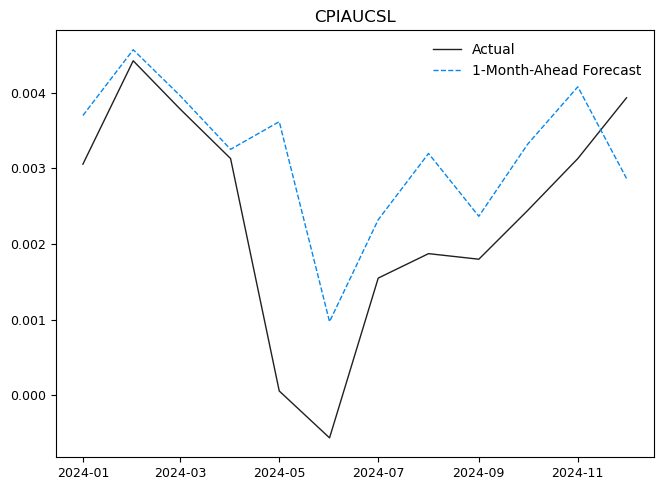

In [42]:
plt.subplots(figsize=(9, 5))
plt.plot(predictions["Actual"], color="#202020", lw=1, label="Actual")
plt.plot(predictions["Forecast"], "--", color="#0588f0", lw=1, label="1-Month-Ahead Forecast")
plt.tick_params(axis="both", which="major", labelsize=9)
plt.tick_params(axis="both", which="minor", labelsize=9)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 10})
plt.title(target_name, size=12)
plt.tight_layout()
plt.show()

Calculate the error metrics.

In [43]:
errors = pd.DataFrame({
    "RMSE": [format(root_mean_squared_error(y_true=predictions["Actual"], y_pred=predictions["Forecast"]), ".4%")],
    "MAE": [format(mean_absolute_error(y_true=predictions["Actual"], y_pred=predictions["Forecast"]), ".4%")]
})

In [44]:
errors

,RMSE,MAE
0,0.1322%,0.0978%
